# Training

In [ ]:
!pip install -q albumentations==0.4.5
!pip install -q efficientnet_pytorch
!pip install -q catalyst

In [ ]:
import os
import cv2
import time

import pandas as pd

import warnings
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from efficientnet_pytorch import EfficientNet

import albumentations as A
from albumentations.pytorch import ToTensorV2

from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.sampler import SequentialSampler

In [ ]:
import random
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
df = pd.read_csv("/content/dataset_folds.csv")

In [ ]:
df.Label.value_counts()

Pinto Beans                   765
Yellow Lentils                664
Adzuki Beans                  632
Chickpeas                     622
Red Lentils                   586
Red Kidney Beans              577
White Kidney Beans            575
Green Gram                    564
Split & Skinned Black Gram    557
Green Chickpeas               551
Black Gram                    527
Split Black Gram              488
Dew Bean                      398
Split Green Gram              220
Name: Label, dtype: int64

## Get Model


In [ ]:
def Net(model_name = 'b0', output = 14):
    model = EfficientNet.from_pretrained(f'efficientnet-{model_name}')
    model._fc = nn.Linear(in_features = model._fc.in_features, out_features = output, bias = True)
    return model

## DataLoader


In [ ]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{Config.DIR}/{image_id}', cv2.IMREAD_COLOR)

        label = self.labels[idx]

        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image, label

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        
        return list(self.labels)

## Augmentations

In [ ]:
def train_augmentaions(img_size = 512):
    return A.Compose([
            A.Resize(height=img_size, width=img_size, p=1),
            A.RandomSizedCrop(min_max_height=(int(img_size-0.2*img_size), int(img_size-0.2*img_size)), height=img_size, width=img_size, p=0.5), # 20% of height and width to be reduced
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.CoarseDropout(max_holes=8, max_width=12, max_height=12, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),                  
        ], p=1.0)

def validation_augmentations(img_size = 512):
    return A.Compose([
            A.Resize(height=img_size, width=img_size, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

## Configuration

In [ ]:
class Config:

  DIR = "/content/dataset"
  output = 14

  num_workers=4
  batch_size=32

  img_size = 224

  n_epoches=100

  lr = 0.0003

  patience=5
  
  SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
  scheduler_params = dict(
      mode='min',
      factor=0.8,
      patience=1,
      verbose=True, 
      threshold=0.0001,
      threshold_mode='abs',
      cooldown=0, 
      min_lr=1e-8,
      eps=1e-08
  )

## Trainer

In [ ]:
train_loss=dict()
valid_loss=dict()

class Engine:
    
    def __init__(self,model,device,config,fold,model_name='b0',image_size=384, weight_path='./'):
  
        self.model=model
        self.device=device
        self.config=config
        self.best_score=0
        self.best_loss=5000
        self.fold=fold
        self.model_name = model_name
        self.image_size = image_size
        self.weight_path = weight_path
        
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 
        
        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.lr)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        
    def fit(self,train_loader,validation_loader):
        for epoch in range(self.config.n_epoches):

            print("Training Started...")
            t=time.time()
            summary_loss = self.train_one_epoch(train_loader)
            train_loss[epoch] = summary_loss.avg

            print('Train : Epoch {:03}: | Summary Loss: {:.3f} | Training time: {}'.format(epoch,summary_loss.avg,time.time() - t))
            
            t=time.time()
            print("Validation Started...")
            summary_loss = self.validation(validation_loader)
            valid_loss[epoch] = summary_loss.avg

            print('Valid : Epoch {:03}: | Summary Loss: {:.3f} | Training time: {}'.format(epoch,summary_loss.avg,time.time() - t))
            
            self.scheduler.step(metrics=summary_loss.avg)
            
            if not self.best_score:
                self.best_score = summary_loss.avg  # So any validation roc_auc we have is the best one for now
                print('Saving model with best val as {}'.format(self.best_score))
                self.model.eval()   
                patience = self.config.patience
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
                continue  

            if summary_loss.avg <= self.best_score:
                self.best_score = summary_loss.avg
                patience = self.config.patience  # Resetting patience since we have new best validation accuracy
                print('Imporved model with best val as {}'.format(self.best_score))
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
            else:
                patience -= 1
                print('Patience Reduced')
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(self.best_score))
                    break
                    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()

        t = time.time()

        for steps,(images, targets) in enumerate(tqdm_notebook(val_loader)):
            with torch.no_grad():
                targets = targets.to(self.device, dtype=torch.long)
                batch_size = images.shape[0]               
                images = images.to(self.device, dtype=torch.float32)
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss


    def train_one_epoch(self, train_loader):
        self.model.train()

        summary_loss = AverageMeter()

        t = time.time()

        for steps,(images, targets) in enumerate(tqdm_notebook(train_loader)):
            targets = targets.to(self.device, dtype=torch.long)
            batch_size = images.shape[0]               
            images = images.to(self.device, dtype=torch.float32)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss
                           

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Engine

In [ ]:
def perform_for_fold(fold_number=0, model_name='b3', image_size=512, weight_path='./', load_weights_path=None):
  
  train_X = df[df["k-fold"] != fold_number].Path.values
  #train_Y = df[df["k-fold"] != fold_number].iloc[:,4:].values
  train_Y = df[df["k-fold"] != fold_number].Label_enc.values

  valid_X = df[df["k-fold"] == fold_number].Path.values
  #valid_Y = df[df["k-fold"] == fold_number].iloc[:,4:].values
  valid_Y = df[df["k-fold"] == fold_number].Label_enc.values


  train_dataset = DatasetRetriever(train_X, train_Y, train_augmentaions(img_size = image_size))
  valid_dataset = DatasetRetriever(valid_X, valid_Y, validation_augmentations(img_size = image_size))

  train_loader = torch.utils.data.DataLoader(
            train_dataset,
            sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
            #sampler=RandomSampler(train_dataset),
            batch_size=Config.batch_size,
            pin_memory=False,
            drop_last=True,
            num_workers=Config.num_workers,
        )
        
  validation_loader = torch.utils.data.DataLoader(
            valid_dataset, 
            batch_size=Config.batch_size,
            num_workers=Config.num_workers,
            shuffle=False,
            sampler=SequentialSampler(valid_dataset),
            pin_memory=False,
        ) 
  
  model = Net(model_name=model_name).cuda()
  if load_weights_path is not None:
    model.load_state_dict(torch.load(load_weights_path + f"{image_size}_Cris_{model_name}_{fold_number}.pt")["model_state_dict"]) 
    print("Weight Loaded")
  engine = Engine(model=model, device=torch.device('cuda'), config=Config, fold=fold_number, model_name=model_name, image_size=image_size, weight_path=weight_path)
  engine.fit(train_loader, validation_loader)

## Training B0: Img_Size: 224

In [ ]:
perform_for_fold(fold_number=0, model_name='b0', image_size=224)

Loaded pretrained weights for efficientnet-b0
Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Train : Epoch 000: | Summary Loss: 1.497 | Training time: 47.344475746154785
Validation Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Valid : Epoch 000: | Summary Loss: 1.908 | Training time: 27.69109582901001
Saving model with best val as 1.9075263959161677
Training Started...



Train : Epoch 001: | Summary Loss: 0.449 | Training time: 46.9659104347229
Validation Started...



Valid : Epoch 001: | Summary Loss: 0.398 | Training time: 27.68668007850647
Imporved model with best val as 0.39838438192900527
Training Started...



Train : Epoch 002: | Summary Loss: 0.307 | Training time: 47.71766209602356
Validation Started...



Valid : Epoch 002: | Summary Loss: 0.212 | Training time: 27.63316774368286
Imporved model with best val as 0.2118025062290077
Training Started...



Train : Epoch 003: | Summary Loss: 0.270 | Training time: 47.044203758239746
Validation Started...



Valid : Epoch 003: | Summary Loss: 0.155 | Training time: 27.488528728485107
Imporved model with best val as 0.15476402183958507
Training Started...



Train : Epoch 004: | Summary Loss: 0.205 | Training time: 44.758004903793335
Validation Started...



Valid : Epoch 004: | Summary Loss: 0.176 | Training time: 27.344966411590576
Patience Reduced
Training Started...



Train : Epoch 005: | Summary Loss: 0.203 | Training time: 46.35668706893921
Validation Started...



Valid : Epoch 005: | Summary Loss: 0.164 | Training time: 27.430235862731934
Epoch     6: reducing learning rate of group 0 to 2.4000e-04.
Epoch     6: reducing learning rate of group 1 to 2.4000e-04.
Patience Reduced
Training Started...



Train : Epoch 006: | Summary Loss: 0.159 | Training time: 46.365256547927856
Validation Started...



Valid : Epoch 006: | Summary Loss: 0.124 | Training time: 27.31919574737549
Imporved model with best val as 0.12422142980829903
Training Started...



Train : Epoch 007: | Summary Loss: 0.141 | Training time: 45.65061283111572
Validation Started...



Valid : Epoch 007: | Summary Loss: 0.125 | Training time: 27.42085552215576
Patience Reduced
Training Started...



Train : Epoch 008: | Summary Loss: 0.123 | Training time: 45.000176668167114
Validation Started...



Valid : Epoch 008: | Summary Loss: 0.123 | Training time: 27.451109170913696
Imporved model with best val as 0.12335358399965284
Training Started...



Train : Epoch 009: | Summary Loss: 0.112 | Training time: 44.960200548172
Validation Started...



Valid : Epoch 009: | Summary Loss: 0.122 | Training time: 27.586878061294556
Imporved model with best val as 0.12182262934079299
Training Started...



Train : Epoch 010: | Summary Loss: 0.121 | Training time: 45.44369149208069
Validation Started...



Valid : Epoch 010: | Summary Loss: 0.126 | Training time: 27.384794235229492
Patience Reduced
Training Started...



Train : Epoch 011: | Summary Loss: 0.115 | Training time: 45.04782319068909
Validation Started...



Valid : Epoch 011: | Summary Loss: 0.100 | Training time: 27.432061672210693
Imporved model with best val as 0.10027072694089943
Training Started...



Train : Epoch 012: | Summary Loss: 0.092 | Training time: 46.19123721122742
Validation Started...



Valid : Epoch 012: | Summary Loss: 0.110 | Training time: 27.497820377349854
Patience Reduced
Training Started...



Train : Epoch 013: | Summary Loss: 0.105 | Training time: 44.37490725517273
Validation Started...



Valid : Epoch 013: | Summary Loss: 0.097 | Training time: 27.388989448547363
Imporved model with best val as 0.09665720773576778
Training Started...



Train : Epoch 014: | Summary Loss: 0.077 | Training time: 45.6383490562439
Validation Started...



Valid : Epoch 014: | Summary Loss: 0.091 | Training time: 27.291260719299316
Imporved model with best val as 0.0906689120739708
Training Started...



Train : Epoch 015: | Summary Loss: 0.086 | Training time: 43.88455080986023
Validation Started...



Valid : Epoch 015: | Summary Loss: 0.091 | Training time: 27.36405658721924
Patience Reduced
Training Started...



Train : Epoch 016: | Summary Loss: 0.070 | Training time: 45.99635148048401
Validation Started...



Valid : Epoch 016: | Summary Loss: 0.090 | Training time: 27.213754415512085
Imporved model with best val as 0.09004190686075403
Training Started...



Train : Epoch 017: | Summary Loss: 0.075 | Training time: 44.074575901031494
Validation Started...



Valid : Epoch 017: | Summary Loss: 0.087 | Training time: 27.38641333580017
Imporved model with best val as 0.08652899683825732
Training Started...



Train : Epoch 018: | Summary Loss: 0.068 | Training time: 44.31487989425659
Validation Started...



Valid : Epoch 018: | Summary Loss: 0.083 | Training time: 27.263399839401245
Imporved model with best val as 0.08269540834077814
Training Started...



Train : Epoch 019: | Summary Loss: 0.077 | Training time: 46.08370780944824
Validation Started...



Valid : Epoch 019: | Summary Loss: 0.093 | Training time: 27.2999210357666
Patience Reduced
Training Started...



Train : Epoch 020: | Summary Loss: 0.063 | Training time: 45.347583532333374
Validation Started...



Valid : Epoch 020: | Summary Loss: 0.085 | Training time: 27.406087636947632
Epoch    21: reducing learning rate of group 0 to 1.9200e-04.
Epoch    21: reducing learning rate of group 1 to 1.9200e-04.
Patience Reduced
Training Started...



Train : Epoch 021: | Summary Loss: 0.056 | Training time: 45.06565999984741
Validation Started...



Valid : Epoch 021: | Summary Loss: 0.090 | Training time: 27.45179843902588
Patience Reduced
Training Started...



Train : Epoch 022: | Summary Loss: 0.061 | Training time: 43.90641736984253
Validation Started...



Valid : Epoch 022: | Summary Loss: 0.081 | Training time: 27.559619188308716
Imporved model with best val as 0.08062526818836543
Training Started...



Train : Epoch 023: | Summary Loss: 0.048 | Training time: 45.33599829673767
Validation Started...



Valid : Epoch 023: | Summary Loss: 0.090 | Training time: 27.462426900863647
Patience Reduced
Training Started...



Train : Epoch 024: | Summary Loss: 0.064 | Training time: 44.33879494667053
Validation Started...



Valid : Epoch 024: | Summary Loss: 0.093 | Training time: 27.410587787628174
Epoch    25: reducing learning rate of group 0 to 1.5360e-04.
Epoch    25: reducing learning rate of group 1 to 1.5360e-04.
Patience Reduced
Training Started...



Train : Epoch 025: | Summary Loss: 0.052 | Training time: 45.385905027389526
Validation Started...



Valid : Epoch 025: | Summary Loss: 0.099 | Training time: 27.448680639266968
Patience Reduced
Training Started...



Train : Epoch 026: | Summary Loss: 0.045 | Training time: 45.76177215576172
Validation Started...



Valid : Epoch 026: | Summary Loss: 0.085 | Training time: 27.659016609191895
Epoch    27: reducing learning rate of group 0 to 1.2288e-04.
Epoch    27: reducing learning rate of group 1 to 1.2288e-04.
Patience Reduced
Training Started...



Train : Epoch 027: | Summary Loss: 0.036 | Training time: 45.02239990234375
Validation Started...



Valid : Epoch 027: | Summary Loss: 0.084 | Training time: 27.45490789413452
Patience Reduced
Early stopping. Best Val roc_auc: 0.081


In [ ]:
perform_for_fold(fold_number=1, model_name='b0', image_size=224)

Loaded pretrained weights for efficientnet-b0
Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Train : Epoch 000: | Summary Loss: 1.522 | Training time: 48.4538950920105
Validation Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Valid : Epoch 000: | Summary Loss: 1.867 | Training time: 25.077125787734985
Saving model with best val as 1.8672483357796776
Training Started...



Train : Epoch 001: | Summary Loss: 0.494 | Training time: 46.1254620552063
Validation Started...



Valid : Epoch 001: | Summary Loss: 0.393 | Training time: 24.914905071258545
Imporved model with best val as 0.3928770173039637
Training Started...



Train : Epoch 002: | Summary Loss: 0.361 | Training time: 46.84367918968201
Validation Started...



Valid : Epoch 002: | Summary Loss: 0.159 | Training time: 24.760298013687134
Imporved model with best val as 0.15895198806879204
Training Started...



Train : Epoch 003: | Summary Loss: 0.278 | Training time: 48.03200674057007
Validation Started...



Valid : Epoch 003: | Summary Loss: 0.134 | Training time: 24.94806480407715
Imporved model with best val as 0.13368846992314054
Training Started...



Train : Epoch 004: | Summary Loss: 0.208 | Training time: 49.07073450088501
Validation Started...



Valid : Epoch 004: | Summary Loss: 0.140 | Training time: 24.831515073776245
Patience Reduced
Training Started...



Train : Epoch 005: | Summary Loss: 0.196 | Training time: 49.060184478759766
Validation Started...



Valid : Epoch 005: | Summary Loss: 0.123 | Training time: 24.60673975944519
Imporved model with best val as 0.12290326871436005
Training Started...



Train : Epoch 006: | Summary Loss: 0.178 | Training time: 46.4689679145813
Validation Started...



Valid : Epoch 006: | Summary Loss: 0.106 | Training time: 24.56800389289856
Imporved model with best val as 0.10578554393693468
Training Started...



Train : Epoch 007: | Summary Loss: 0.158 | Training time: 46.85840845108032
Validation Started...



Valid : Epoch 007: | Summary Loss: 0.084 | Training time: 24.621773719787598
Imporved model with best val as 0.08370833781978845
Training Started...



Train : Epoch 008: | Summary Loss: 0.126 | Training time: 47.651878356933594
Validation Started...



Valid : Epoch 008: | Summary Loss: 0.071 | Training time: 24.60731554031372
Imporved model with best val as 0.07111178752740176
Training Started...



Train : Epoch 009: | Summary Loss: 0.148 | Training time: 47.591498374938965
Validation Started...



Valid : Epoch 009: | Summary Loss: 0.083 | Training time: 24.769641876220703
Patience Reduced
Training Started...



Train : Epoch 010: | Summary Loss: 0.125 | Training time: 47.57693696022034
Validation Started...



Valid : Epoch 010: | Summary Loss: 0.067 | Training time: 24.551345109939575
Imporved model with best val as 0.06745674828712415
Training Started...



Train : Epoch 011: | Summary Loss: 0.119 | Training time: 46.14052748680115
Validation Started...



Valid : Epoch 011: | Summary Loss: 0.075 | Training time: 24.520983934402466
Patience Reduced
Training Started...



Train : Epoch 012: | Summary Loss: 0.095 | Training time: 47.553348779678345
Validation Started...



Valid : Epoch 012: | Summary Loss: 0.075 | Training time: 24.6782169342041
Epoch    13: reducing learning rate of group 0 to 2.4000e-04.
Epoch    13: reducing learning rate of group 1 to 2.4000e-04.
Patience Reduced
Training Started...



Train : Epoch 013: | Summary Loss: 0.092 | Training time: 45.153934478759766
Validation Started...



Valid : Epoch 013: | Summary Loss: 0.079 | Training time: 24.653162956237793
Patience Reduced
Training Started...



Train : Epoch 014: | Summary Loss: 0.096 | Training time: 45.62866234779358
Validation Started...



Valid : Epoch 014: | Summary Loss: 0.080 | Training time: 24.552654027938843
Epoch    15: reducing learning rate of group 0 to 1.9200e-04.
Epoch    15: reducing learning rate of group 1 to 1.9200e-04.
Patience Reduced
Training Started...



Train : Epoch 015: | Summary Loss: 0.065 | Training time: 45.891849517822266
Validation Started...



Valid : Epoch 015: | Summary Loss: 0.061 | Training time: 24.7314453125
Imporved model with best val as 0.061056405026767055
Training Started...



Train : Epoch 016: | Summary Loss: 0.063 | Training time: 45.953673124313354
Validation Started...



Valid : Epoch 016: | Summary Loss: 0.063 | Training time: 24.63936734199524
Patience Reduced
Training Started...



Train : Epoch 017: | Summary Loss: 0.058 | Training time: 45.8168408870697
Validation Started...



Valid : Epoch 017: | Summary Loss: 0.067 | Training time: 25.065772771835327
Epoch    18: reducing learning rate of group 0 to 1.5360e-04.
Epoch    18: reducing learning rate of group 1 to 1.5360e-04.
Patience Reduced
Training Started...



Train : Epoch 018: | Summary Loss: 0.047 | Training time: 48.26502442359924
Validation Started...



Valid : Epoch 018: | Summary Loss: 0.057 | Training time: 25.287007570266724
Imporved model with best val as 0.05737359340899416
Training Started...



Train : Epoch 019: | Summary Loss: 0.054 | Training time: 47.74487638473511
Validation Started...



Valid : Epoch 019: | Summary Loss: 0.056 | Training time: 25.30874538421631
Imporved model with best val as 0.056399533292730744
Training Started...



Train : Epoch 020: | Summary Loss: 0.052 | Training time: 48.36014938354492
Validation Started...



Valid : Epoch 020: | Summary Loss: 0.056 | Training time: 25.809653759002686
Imporved model with best val as 0.05579888261040872
Training Started...



Train : Epoch 021: | Summary Loss: 0.046 | Training time: 47.365113496780396
Validation Started...



Valid : Epoch 021: | Summary Loss: 0.049 | Training time: 26.112430572509766
Imporved model with best val as 0.049019998761985005
Training Started...



Train : Epoch 022: | Summary Loss: 0.044 | Training time: 48.887452602386475
Validation Started...



Valid : Epoch 022: | Summary Loss: 0.052 | Training time: 26.211666584014893
Patience Reduced
Training Started...



Train : Epoch 023: | Summary Loss: 0.043 | Training time: 48.669601917266846
Validation Started...



Valid : Epoch 023: | Summary Loss: 0.058 | Training time: 26.198986053466797
Epoch    24: reducing learning rate of group 0 to 1.2288e-04.
Epoch    24: reducing learning rate of group 1 to 1.2288e-04.
Patience Reduced
Training Started...



Train : Epoch 024: | Summary Loss: 0.050 | Training time: 50.04376173019409
Validation Started...



Valid : Epoch 024: | Summary Loss: 0.062 | Training time: 25.864423274993896
Patience Reduced
Training Started...



Train : Epoch 025: | Summary Loss: 0.036 | Training time: 49.044074296951294
Validation Started...



Valid : Epoch 025: | Summary Loss: 0.061 | Training time: 25.757052659988403
Epoch    26: reducing learning rate of group 0 to 9.8304e-05.
Epoch    26: reducing learning rate of group 1 to 9.8304e-05.
Patience Reduced
Training Started...



Train : Epoch 026: | Summary Loss: 0.044 | Training time: 49.81282687187195
Validation Started...



Valid : Epoch 026: | Summary Loss: 0.056 | Training time: 26.213128089904785
Patience Reduced
Early stopping. Best Val roc_auc: 0.049


In [ ]:
perform_for_fold(fold_number=2, model_name='b0', image_size=224)

Loaded pretrained weights for efficientnet-b0
Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Train : Epoch 000: | Summary Loss: 1.532 | Training time: 48.28135895729065
Validation Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Valid : Epoch 000: | Summary Loss: 1.993 | Training time: 28.87967038154602
Saving model with best val as 1.9927239273744108
Training Started...



Train : Epoch 001: | Summary Loss: 0.481 | Training time: 48.74021506309509
Validation Started...



Valid : Epoch 001: | Summary Loss: 0.312 | Training time: 28.918326377868652
Imporved model with best val as 0.31227304678422346
Training Started...



Train : Epoch 002: | Summary Loss: 0.294 | Training time: 51.08491516113281
Validation Started...



Valid : Epoch 002: | Summary Loss: 0.222 | Training time: 29.00489354133606
Imporved model with best val as 0.22206744543219462
Training Started...



Train : Epoch 003: | Summary Loss: 0.278 | Training time: 49.65925312042236
Validation Started...



Valid : Epoch 003: | Summary Loss: 0.162 | Training time: 29.095075130462646
Imporved model with best val as 0.16193024138272002
Training Started...



Train : Epoch 004: | Summary Loss: 0.214 | Training time: 49.342652797698975
Validation Started...



Valid : Epoch 004: | Summary Loss: 0.148 | Training time: 29.16460132598877
Imporved model with best val as 0.1481783447961977
Training Started...



Train : Epoch 005: | Summary Loss: 0.194 | Training time: 50.7234833240509
Validation Started...



Valid : Epoch 005: | Summary Loss: 0.138 | Training time: 29.097607135772705
Imporved model with best val as 0.13757192763141252
Training Started...



Train : Epoch 006: | Summary Loss: 0.144 | Training time: 47.9020357131958
Validation Started...



Valid : Epoch 006: | Summary Loss: 0.136 | Training time: 28.211730003356934
Imporved model with best val as 0.13592262070499433
Training Started...



Train : Epoch 007: | Summary Loss: 0.150 | Training time: 48.699556827545166
Validation Started...



Valid : Epoch 007: | Summary Loss: 0.133 | Training time: 28.594610929489136
Imporved model with best val as 0.1326950595711138
Training Started...



Train : Epoch 008: | Summary Loss: 0.132 | Training time: 48.88846945762634
Validation Started...



Valid : Epoch 008: | Summary Loss: 0.124 | Training time: 28.24748992919922
Imporved model with best val as 0.12432033104662298
Training Started...



Train : Epoch 009: | Summary Loss: 0.107 | Training time: 46.99782991409302
Validation Started...



Valid : Epoch 009: | Summary Loss: 0.117 | Training time: 27.998961687088013
Imporved model with best val as 0.11740441079640272
Training Started...



Train : Epoch 010: | Summary Loss: 0.143 | Training time: 46.85985064506531
Validation Started...



Valid : Epoch 010: | Summary Loss: 0.113 | Training time: 28.001816034317017
Imporved model with best val as 0.11324847518529707
Training Started...



Train : Epoch 011: | Summary Loss: 0.110 | Training time: 47.63993263244629
Validation Started...



Valid : Epoch 011: | Summary Loss: 0.106 | Training time: 28.785651683807373
Imporved model with best val as 0.10634756268493373
Training Started...



Train : Epoch 012: | Summary Loss: 0.106 | Training time: 47.792882442474365
Validation Started...



Valid : Epoch 012: | Summary Loss: 0.094 | Training time: 28.249335050582886
Imporved model with best val as 0.09424943317475346
Training Started...



Train : Epoch 013: | Summary Loss: 0.093 | Training time: 48.09678912162781
Validation Started...



Valid : Epoch 013: | Summary Loss: 0.099 | Training time: 27.951757192611694
Patience Reduced
Training Started...



Train : Epoch 014: | Summary Loss: 0.087 | Training time: 49.4227180480957
Validation Started...



Valid : Epoch 014: | Summary Loss: 0.100 | Training time: 28.169845581054688
Epoch    15: reducing learning rate of group 0 to 2.4000e-04.
Epoch    15: reducing learning rate of group 1 to 2.4000e-04.
Patience Reduced
Training Started...



Train : Epoch 015: | Summary Loss: 0.101 | Training time: 49.271994829177856
Validation Started...



Valid : Epoch 015: | Summary Loss: 0.099 | Training time: 28.57122802734375
Patience Reduced
Training Started...



Train : Epoch 016: | Summary Loss: 0.079 | Training time: 50.18049955368042
Validation Started...



Valid : Epoch 016: | Summary Loss: 0.084 | Training time: 28.786875247955322
Imporved model with best val as 0.08392279257057506
Training Started...



Train : Epoch 017: | Summary Loss: 0.059 | Training time: 49.48001265525818
Validation Started...



Valid : Epoch 017: | Summary Loss: 0.094 | Training time: 28.531212329864502
Patience Reduced
Training Started...



Train : Epoch 018: | Summary Loss: 0.058 | Training time: 49.16930651664734
Validation Started...



Valid : Epoch 018: | Summary Loss: 0.101 | Training time: 28.368019580841064
Epoch    19: reducing learning rate of group 0 to 1.9200e-04.
Epoch    19: reducing learning rate of group 1 to 1.9200e-04.
Patience Reduced
Training Started...



Train : Epoch 019: | Summary Loss: 0.069 | Training time: 48.964340925216675
Validation Started...



Valid : Epoch 019: | Summary Loss: 0.088 | Training time: 28.795660972595215
Patience Reduced
Training Started...



Train : Epoch 020: | Summary Loss: 0.048 | Training time: 48.499070167541504
Validation Started...



Valid : Epoch 020: | Summary Loss: 0.083 | Training time: 28.931370496749878
Imporved model with best val as 0.08283248058229031
Training Started...



Train : Epoch 021: | Summary Loss: 0.052 | Training time: 49.936814069747925
Validation Started...



Valid : Epoch 021: | Summary Loss: 0.082 | Training time: 28.778857707977295
Imporved model with best val as 0.08207088430558292
Training Started...



Train : Epoch 022: | Summary Loss: 0.042 | Training time: 48.594266414642334
Validation Started...



Valid : Epoch 022: | Summary Loss: 0.081 | Training time: 28.717709064483643
Imporved model with best val as 0.0807932494504341
Training Started...



Train : Epoch 023: | Summary Loss: 0.048 | Training time: 49.23838019371033
Validation Started...



Valid : Epoch 023: | Summary Loss: 0.082 | Training time: 29.061986446380615
Patience Reduced
Training Started...



Train : Epoch 024: | Summary Loss: 0.048 | Training time: 49.83713936805725
Validation Started...



Valid : Epoch 024: | Summary Loss: 0.082 | Training time: 29.567339658737183
Epoch    25: reducing learning rate of group 0 to 1.5360e-04.
Epoch    25: reducing learning rate of group 1 to 1.5360e-04.
Patience Reduced
Training Started...



Train : Epoch 025: | Summary Loss: 0.038 | Training time: 47.09065628051758
Validation Started...



Valid : Epoch 025: | Summary Loss: 0.085 | Training time: 29.132049560546875
Patience Reduced
Training Started...



Train : Epoch 026: | Summary Loss: 0.033 | Training time: 50.75515627861023
Validation Started...



Valid : Epoch 026: | Summary Loss: 0.087 | Training time: 29.378942012786865
Epoch    27: reducing learning rate of group 0 to 1.2288e-04.
Epoch    27: reducing learning rate of group 1 to 1.2288e-04.
Patience Reduced
Training Started...



Train : Epoch 027: | Summary Loss: 0.045 | Training time: 49.32219099998474
Validation Started...



Valid : Epoch 027: | Summary Loss: 0.080 | Training time: 29.165002822875977
Imporved model with best val as 0.07951829823391048
Training Started...



Train : Epoch 028: | Summary Loss: 0.035 | Training time: 48.0568482875824
Validation Started...



Valid : Epoch 028: | Summary Loss: 0.083 | Training time: 29.4294536113739
Patience Reduced
Training Started...



Train : Epoch 029: | Summary Loss: 0.027 | Training time: 50.850460052490234
Validation Started...



Valid : Epoch 029: | Summary Loss: 0.083 | Training time: 29.555673837661743
Epoch    30: reducing learning rate of group 0 to 9.8304e-05.
Epoch    30: reducing learning rate of group 1 to 9.8304e-05.
Patience Reduced
Training Started...



Train : Epoch 030: | Summary Loss: 0.038 | Training time: 48.378448486328125
Validation Started...



Valid : Epoch 030: | Summary Loss: 0.080 | Training time: 29.77707314491272
Patience Reduced
Training Started...



Train : Epoch 031: | Summary Loss: 0.030 | Training time: 50.4256546497345
Validation Started...



Valid : Epoch 031: | Summary Loss: 0.081 | Training time: 29.58469009399414
Epoch    32: reducing learning rate of group 0 to 7.8643e-05.
Epoch    32: reducing learning rate of group 1 to 7.8643e-05.
Patience Reduced
Training Started...



Train : Epoch 032: | Summary Loss: 0.031 | Training time: 48.32491588592529
Validation Started...



Valid : Epoch 032: | Summary Loss: 0.082 | Training time: 29.59855628013611
Patience Reduced
Early stopping. Best Val roc_auc: 0.080


In [ ]:
perform_for_fold(fold_number=3, model_name='b0', image_size=224)

Loaded pretrained weights for efficientnet-b0
Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Train : Epoch 000: | Summary Loss: 1.473 | Training time: 49.778754234313965
Validation Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Valid : Epoch 000: | Summary Loss: 1.760 | Training time: 30.908942222595215
Saving model with best val as 1.7600756855072712
Training Started...



Train : Epoch 001: | Summary Loss: 0.446 | Training time: 50.705769538879395
Validation Started...



Valid : Epoch 001: | Summary Loss: 0.519 | Training time: 31.050087213516235
Imporved model with best val as 0.5192533189039015
Training Started...



Train : Epoch 002: | Summary Loss: 0.319 | Training time: 52.041242361068726
Validation Started...



Valid : Epoch 002: | Summary Loss: 0.232 | Training time: 31.08042001724243
Imporved model with best val as 0.23179856402540283
Training Started...



Train : Epoch 003: | Summary Loss: 0.279 | Training time: 48.35331463813782
Validation Started...



Valid : Epoch 003: | Summary Loss: 0.179 | Training time: 30.848634481430054
Imporved model with best val as 0.17926654826765306
Training Started...



Train : Epoch 004: | Summary Loss: 0.228 | Training time: 48.7813982963562
Validation Started...



Valid : Epoch 004: | Summary Loss: 0.152 | Training time: 31.147926330566406
Imporved model with best val as 0.15208892022473527
Training Started...



Train : Epoch 005: | Summary Loss: 0.194 | Training time: 49.24103236198425
Validation Started...



Valid : Epoch 005: | Summary Loss: 0.109 | Training time: 31.471505880355835
Imporved model with best val as 0.10934068475726352
Training Started...



Train : Epoch 006: | Summary Loss: 0.156 | Training time: 50.86802816390991
Validation Started...



Valid : Epoch 006: | Summary Loss: 0.142 | Training time: 29.802417516708374
Patience Reduced
Training Started...



Train : Epoch 007: | Summary Loss: 0.168 | Training time: 49.98803782463074
Validation Started...



Valid : Epoch 007: | Summary Loss: 0.120 | Training time: 30.373770475387573
Epoch     8: reducing learning rate of group 0 to 2.4000e-04.
Epoch     8: reducing learning rate of group 1 to 2.4000e-04.
Patience Reduced
Training Started...



Train : Epoch 008: | Summary Loss: 0.129 | Training time: 47.402246952056885
Validation Started...



Valid : Epoch 008: | Summary Loss: 0.108 | Training time: 30.54418969154358
Imporved model with best val as 0.1084058517608249
Training Started...



Train : Epoch 009: | Summary Loss: 0.103 | Training time: 49.28745150566101
Validation Started...



Valid : Epoch 009: | Summary Loss: 0.099 | Training time: 30.706297397613525
Imporved model with best val as 0.09933725310471452
Training Started...



Train : Epoch 010: | Summary Loss: 0.103 | Training time: 49.849393129348755
Validation Started...



Valid : Epoch 010: | Summary Loss: 0.090 | Training time: 30.67445993423462
Imporved model with best val as 0.0895790871781294
Training Started...



Train : Epoch 011: | Summary Loss: 0.107 | Training time: 49.81569218635559
Validation Started...



Valid : Epoch 011: | Summary Loss: 0.093 | Training time: 30.68900990486145
Patience Reduced
Training Started...



Train : Epoch 012: | Summary Loss: 0.096 | Training time: 50.46114540100098
Validation Started...



Valid : Epoch 012: | Summary Loss: 0.087 | Training time: 30.576507568359375
Imporved model with best val as 0.0874303244729451
Training Started...



Train : Epoch 013: | Summary Loss: 0.110 | Training time: 49.106903076171875
Validation Started...



Valid : Epoch 013: | Summary Loss: 0.093 | Training time: 30.571674823760986
Patience Reduced
Training Started...



Train : Epoch 014: | Summary Loss: 0.088 | Training time: 51.375004053115845
Validation Started...



Valid : Epoch 014: | Summary Loss: 0.087 | Training time: 30.75937271118164
Imporved model with best val as 0.08687234701314477
Training Started...



Train : Epoch 015: | Summary Loss: 0.089 | Training time: 50.581507444381714
Validation Started...



Valid : Epoch 015: | Summary Loss: 0.086 | Training time: 30.971638441085815
Imporved model with best val as 0.08592166031637714
Training Started...



Train : Epoch 016: | Summary Loss: 0.071 | Training time: 52.20693111419678
Validation Started...



Valid : Epoch 016: | Summary Loss: 0.098 | Training time: 30.716747045516968
Patience Reduced
Training Started...



Train : Epoch 017: | Summary Loss: 0.076 | Training time: 48.89740538597107
Validation Started...



Valid : Epoch 017: | Summary Loss: 0.086 | Training time: 30.89353585243225
Imporved model with best val as 0.08562867342883233
Training Started...



Train : Epoch 018: | Summary Loss: 0.084 | Training time: 51.58866095542908
Validation Started...



Valid : Epoch 018: | Summary Loss: 0.086 | Training time: 30.967631340026855
Patience Reduced
Training Started...



Train : Epoch 019: | Summary Loss: 0.078 | Training time: 51.443469285964966
Validation Started...



Valid : Epoch 019: | Summary Loss: 0.101 | Training time: 31.033823251724243
Epoch    20: reducing learning rate of group 0 to 1.9200e-04.
Epoch    20: reducing learning rate of group 1 to 1.9200e-04.
Patience Reduced
Training Started...



Train : Epoch 020: | Summary Loss: 0.064 | Training time: 48.76539635658264
Validation Started...



Valid : Epoch 020: | Summary Loss: 0.086 | Training time: 30.98780608177185
Patience Reduced
Training Started...



Train : Epoch 021: | Summary Loss: 0.046 | Training time: 49.71262454986572
Validation Started...



Valid : Epoch 021: | Summary Loss: 0.081 | Training time: 30.949256420135498
Imporved model with best val as 0.08129514998019428
Training Started...



Train : Epoch 022: | Summary Loss: 0.054 | Training time: 49.795687198638916
Validation Started...



Valid : Epoch 022: | Summary Loss: 0.096 | Training time: 31.267971992492676
Patience Reduced
Training Started...



Train : Epoch 023: | Summary Loss: 0.059 | Training time: 52.43925738334656
Validation Started...



Valid : Epoch 023: | Summary Loss: 0.088 | Training time: 30.982717990875244
Epoch    24: reducing learning rate of group 0 to 1.5360e-04.
Epoch    24: reducing learning rate of group 1 to 1.5360e-04.
Patience Reduced
Training Started...



Train : Epoch 024: | Summary Loss: 0.039 | Training time: 50.49616885185242
Validation Started...



Valid : Epoch 024: | Summary Loss: 0.080 | Training time: 31.10126280784607
Imporved model with best val as 0.0795083893883467
Training Started...



Train : Epoch 025: | Summary Loss: 0.041 | Training time: 51.428943395614624
Validation Started...



Valid : Epoch 025: | Summary Loss: 0.079 | Training time: 30.903943300247192
Imporved model with best val as 0.07928667995509085
Training Started...



Train : Epoch 026: | Summary Loss: 0.046 | Training time: 49.07765984535217
Validation Started...



Valid : Epoch 026: | Summary Loss: 0.081 | Training time: 31.071460485458374
Patience Reduced
Training Started...



Train : Epoch 027: | Summary Loss: 0.035 | Training time: 48.65185236930847
Validation Started...



Valid : Epoch 027: | Summary Loss: 0.076 | Training time: 30.93291974067688
Imporved model with best val as 0.07559670792421828
Training Started...



Train : Epoch 028: | Summary Loss: 0.037 | Training time: 50.34168267250061
Validation Started...



Valid : Epoch 028: | Summary Loss: 0.077 | Training time: 30.85898780822754
Patience Reduced
Training Started...



Train : Epoch 029: | Summary Loss: 0.038 | Training time: 50.050806283950806
Validation Started...



Valid : Epoch 029: | Summary Loss: 0.081 | Training time: 30.747962713241577
Epoch    30: reducing learning rate of group 0 to 1.2288e-04.
Epoch    30: reducing learning rate of group 1 to 1.2288e-04.
Patience Reduced
Training Started...



Train : Epoch 030: | Summary Loss: 0.030 | Training time: 50.1295428276062
Validation Started...



Valid : Epoch 030: | Summary Loss: 0.078 | Training time: 30.847119331359863
Patience Reduced
Training Started...



Train : Epoch 031: | Summary Loss: 0.031 | Training time: 52.73773169517517
Validation Started...



Valid : Epoch 031: | Summary Loss: 0.079 | Training time: 30.854017734527588
Epoch    32: reducing learning rate of group 0 to 9.8304e-05.
Epoch    32: reducing learning rate of group 1 to 9.8304e-05.
Patience Reduced
Training Started...



Train : Epoch 032: | Summary Loss: 0.034 | Training time: 50.7459180355072
Validation Started...



Valid : Epoch 032: | Summary Loss: 0.077 | Training time: 30.978276014328003
Patience Reduced
Early stopping. Best Val roc_auc: 0.076


In [ ]:
perform_for_fold(fold_number=4, model_name='b0', image_size=224)

Loaded pretrained weights for efficientnet-b0
Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Train : Epoch 000: | Summary Loss: 1.440 | Training time: 51.12760853767395
Validation Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Valid : Epoch 000: | Summary Loss: 1.914 | Training time: 30.683366537094116
Saving model with best val as 1.9144082874927706
Training Started...



Train : Epoch 001: | Summary Loss: 0.475 | Training time: 50.40114092826843
Validation Started...



Valid : Epoch 001: | Summary Loss: 0.380 | Training time: 30.497110843658447
Imporved model with best val as 0.3802050131810136
Training Started...



Train : Epoch 002: | Summary Loss: 0.345 | Training time: 48.51342988014221
Validation Started...



Valid : Epoch 002: | Summary Loss: 0.199 | Training time: 30.17972159385681
Imporved model with best val as 0.19910524668816995
Training Started...



Train : Epoch 003: | Summary Loss: 0.258 | Training time: 50.41720795631409
Validation Started...



Valid : Epoch 003: | Summary Loss: 0.158 | Training time: 29.418687105178833
Imporved model with best val as 0.15781917126433362
Training Started...



Train : Epoch 004: | Summary Loss: 0.199 | Training time: 49.35612463951111
Validation Started...



Valid : Epoch 004: | Summary Loss: 0.142 | Training time: 29.535228490829468
Imporved model with best val as 0.14198424603946772
Training Started...



Train : Epoch 005: | Summary Loss: 0.217 | Training time: 49.57695007324219
Validation Started...



Valid : Epoch 005: | Summary Loss: 0.129 | Training time: 29.939210414886475
Imporved model with best val as 0.1293669090398307
Training Started...



Train : Epoch 006: | Summary Loss: 0.166 | Training time: 48.03365898132324
Validation Started...



Valid : Epoch 006: | Summary Loss: 0.132 | Training time: 30.208945274353027
Patience Reduced
Training Started...



Train : Epoch 007: | Summary Loss: 0.145 | Training time: 49.3969841003418
Validation Started...



Valid : Epoch 007: | Summary Loss: 0.134 | Training time: 30.408503770828247
Epoch     8: reducing learning rate of group 0 to 2.4000e-04.
Epoch     8: reducing learning rate of group 1 to 2.4000e-04.
Patience Reduced
Training Started...



Train : Epoch 008: | Summary Loss: 0.131 | Training time: 46.85510778427124
Validation Started...



Valid : Epoch 008: | Summary Loss: 0.087 | Training time: 30.498174905776978
Imporved model with best val as 0.08747617880599784
Training Started...



Train : Epoch 009: | Summary Loss: 0.103 | Training time: 49.97772693634033
Validation Started...



Valid : Epoch 009: | Summary Loss: 0.093 | Training time: 30.620455741882324
Patience Reduced
Training Started...



Train : Epoch 010: | Summary Loss: 0.119 | Training time: 50.52682828903198
Validation Started...



Valid : Epoch 010: | Summary Loss: 0.091 | Training time: 30.25522780418396
Epoch    11: reducing learning rate of group 0 to 1.9200e-04.
Epoch    11: reducing learning rate of group 1 to 1.9200e-04.
Patience Reduced
Training Started...



Train : Epoch 011: | Summary Loss: 0.094 | Training time: 51.32048034667969
Validation Started...



Valid : Epoch 011: | Summary Loss: 0.072 | Training time: 30.358351469039917
Imporved model with best val as 0.07223046110478805
Training Started...



Train : Epoch 012: | Summary Loss: 0.111 | Training time: 50.155370235443115
Validation Started...



Valid : Epoch 012: | Summary Loss: 0.088 | Training time: 30.49691104888916
Patience Reduced
Training Started...



Train : Epoch 013: | Summary Loss: 0.082 | Training time: 49.38810706138611
Validation Started...



Valid : Epoch 013: | Summary Loss: 0.080 | Training time: 30.512895345687866
Epoch    14: reducing learning rate of group 0 to 1.5360e-04.
Epoch    14: reducing learning rate of group 1 to 1.5360e-04.
Patience Reduced
Training Started...



Train : Epoch 014: | Summary Loss: 0.080 | Training time: 48.35013556480408
Validation Started...



Valid : Epoch 014: | Summary Loss: 0.081 | Training time: 30.729214668273926
Patience Reduced
Training Started...



Train : Epoch 015: | Summary Loss: 0.072 | Training time: 51.121564626693726
Validation Started...



Valid : Epoch 015: | Summary Loss: 0.067 | Training time: 30.285260438919067
Imporved model with best val as 0.06710925399292635
Training Started...



Train : Epoch 016: | Summary Loss: 0.063 | Training time: 49.149468183517456
Validation Started...



Valid : Epoch 016: | Summary Loss: 0.074 | Training time: 29.535777807235718
Patience Reduced
Training Started...



Train : Epoch 017: | Summary Loss: 0.057 | Training time: 46.7579882144928
Validation Started...



Valid : Epoch 017: | Summary Loss: 0.074 | Training time: 29.194884538650513
Epoch    18: reducing learning rate of group 0 to 1.2288e-04.
Epoch    18: reducing learning rate of group 1 to 1.2288e-04.
Patience Reduced
Training Started...



Train : Epoch 018: | Summary Loss: 0.057 | Training time: 46.7823588848114
Validation Started...



Valid : Epoch 018: | Summary Loss: 0.072 | Training time: 28.63633894920349
Patience Reduced
Training Started...



Train : Epoch 019: | Summary Loss: 0.053 | Training time: 46.76285696029663
Validation Started...



Valid : Epoch 019: | Summary Loss: 0.075 | Training time: 28.15780234336853
Epoch    20: reducing learning rate of group 0 to 9.8304e-05.
Epoch    20: reducing learning rate of group 1 to 9.8304e-05.
Patience Reduced
Training Started...



Train : Epoch 020: | Summary Loss: 0.049 | Training time: 45.023810386657715
Validation Started...



Valid : Epoch 020: | Summary Loss: 0.066 | Training time: 27.887141466140747
Imporved model with best val as 0.06636049488505114
Training Started...



Train : Epoch 021: | Summary Loss: 0.048 | Training time: 45.0013632774353
Validation Started...



Valid : Epoch 021: | Summary Loss: 0.066 | Training time: 27.875633716583252
Imporved model with best val as 0.06620762095602778
Training Started...



Train : Epoch 022: | Summary Loss: 0.049 | Training time: 44.88463497161865
Validation Started...



Valid : Epoch 022: | Summary Loss: 0.076 | Training time: 27.83985471725464
Patience Reduced
Training Started...



Train : Epoch 023: | Summary Loss: 0.045 | Training time: 46.326858043670654
Validation Started...



Valid : Epoch 023: | Summary Loss: 0.069 | Training time: 27.93783712387085
Epoch    24: reducing learning rate of group 0 to 7.8643e-05.
Epoch    24: reducing learning rate of group 1 to 7.8643e-05.
Patience Reduced
Training Started...



Train : Epoch 024: | Summary Loss: 0.051 | Training time: 46.409642457962036
Validation Started...



Valid : Epoch 024: | Summary Loss: 0.061 | Training time: 27.84838628768921
Imporved model with best val as 0.061100653388377724
Training Started...



Train : Epoch 025: | Summary Loss: 0.047 | Training time: 45.77417182922363
Validation Started...



Valid : Epoch 025: | Summary Loss: 0.065 | Training time: 27.947598457336426
Patience Reduced
Training Started...



Train : Epoch 026: | Summary Loss: 0.037 | Training time: 46.02431297302246
Validation Started...



Valid : Epoch 026: | Summary Loss: 0.067 | Training time: 27.992939233779907
Epoch    27: reducing learning rate of group 0 to 6.2915e-05.
Epoch    27: reducing learning rate of group 1 to 6.2915e-05.
Patience Reduced
Training Started...



Train : Epoch 027: | Summary Loss: 0.043 | Training time: 47.59441089630127
Validation Started...



Valid : Epoch 027: | Summary Loss: 0.065 | Training time: 27.832098722457886
Patience Reduced
Training Started...



Train : Epoch 028: | Summary Loss: 0.047 | Training time: 44.71666884422302
Validation Started...



Valid : Epoch 028: | Summary Loss: 0.064 | Training time: 27.891123056411743
Epoch    29: reducing learning rate of group 0 to 5.0332e-05.
Epoch    29: reducing learning rate of group 1 to 5.0332e-05.
Patience Reduced
Training Started...



Train : Epoch 029: | Summary Loss: 0.036 | Training time: 44.3823504447937
Validation Started...



Valid : Epoch 029: | Summary Loss: 0.063 | Training time: 27.7810378074646
Patience Reduced
Early stopping. Best Val roc_auc: 0.061


In [ ]:
perform_for_fold(fold_number=0, model_name='b0', image_size=224)

Loaded pretrained weights for efficientnet-b0
Training Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Train : Epoch 000: | Summary Loss: 1.520 | Training time: 45.354886293411255
Validation Started...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Valid : Epoch 000: | Summary Loss: 1.960 | Training time: 28.43006920814514
Saving model with best val as 1.96006105448882
Training Started...



Train : Epoch 001: | Summary Loss: 0.462 | Training time: 46.557865619659424
Validation Started...



Valid : Epoch 001: | Summary Loss: 0.424 | Training time: 28.14432954788208
Imporved model with best val as 0.42400066379125184
Training Started...



Train : Epoch 002: | Summary Loss: 0.317 | Training time: 45.95198202133179
Validation Started...



Valid : Epoch 002: | Summary Loss: 0.229 | Training time: 28.013116598129272
Imporved model with best val as 0.22856272393199017
Training Started...



Train : Epoch 003: | Summary Loss: 0.268 | Training time: 45.804991006851196
Validation Started...



Valid : Epoch 003: | Summary Loss: 0.219 | Training time: 28.00916028022766
Imporved model with best val as 0.21904579826653545
Training Started...



Train : Epoch 004: | Summary Loss: 0.228 | Training time: 44.707679986953735
Validation Started...



Valid : Epoch 004: | Summary Loss: 0.167 | Training time: 27.79439878463745
Imporved model with best val as 0.1669711633398647
Training Started...



Train : Epoch 005: | Summary Loss: 0.191 | Training time: 45.182775020599365
Validation Started...



Valid : Epoch 005: | Summary Loss: 0.161 | Training time: 27.73836851119995
Imporved model with best val as 0.1610179325230757
Training Started...



Train : Epoch 006: | Summary Loss: 0.184 | Training time: 47.46848964691162
Validation Started...



Valid : Epoch 006: | Summary Loss: 0.135 | Training time: 27.758501768112183
Imporved model with best val as 0.13496950513563982
Training Started...



Train : Epoch 007: | Summary Loss: 0.132 | Training time: 46.69406533241272
Validation Started...



Valid : Epoch 007: | Summary Loss: 0.142 | Training time: 27.63599419593811
Patience Reduced
Training Started...



Train : Epoch 008: | Summary Loss: 0.135 | Training time: 47.06190299987793
Validation Started...



Valid : Epoch 008: | Summary Loss: 0.130 | Training time: 27.53188467025757
Imporved model with best val as 0.1299887617464439
Training Started...



Train : Epoch 009: | Summary Loss: 0.128 | Training time: 48.10206413269043
Validation Started...



Valid : Epoch 009: | Summary Loss: 0.149 | Training time: 27.486135005950928
Patience Reduced
Training Started...



Train : Epoch 010: | Summary Loss: 0.126 | Training time: 45.91819453239441
Validation Started...



Valid : Epoch 010: | Summary Loss: 0.106 | Training time: 27.69193983078003
Imporved model with best val as 0.10630467816835502
Training Started...



Train : Epoch 011: | Summary Loss: 0.100 | Training time: 47.95228290557861
Validation Started...



Valid : Epoch 011: | Summary Loss: 0.111 | Training time: 27.64068055152893
Patience Reduced
Training Started...



Train : Epoch 012: | Summary Loss: 0.110 | Training time: 45.87682342529297
Validation Started...



Valid : Epoch 012: | Summary Loss: 0.107 | Training time: 27.519389629364014
Epoch    13: reducing learning rate of group 0 to 2.4000e-04.
Epoch    13: reducing learning rate of group 1 to 2.4000e-04.
Patience Reduced
Training Started...



Train : Epoch 013: | Summary Loss: 0.095 | Training time: 46.345417499542236
Validation Started...



Valid : Epoch 013: | Summary Loss: 0.104 | Training time: 27.611660480499268
Imporved model with best val as 0.10384821185160231
Training Started...



Train : Epoch 014: | Summary Loss: 0.104 | Training time: 46.33323359489441
Validation Started...



Valid : Epoch 014: | Summary Loss: 0.104 | Training time: 27.786232233047485
Patience Reduced
Training Started...



Train : Epoch 015: | Summary Loss: 0.072 | Training time: 47.09152317047119
Validation Started...



Valid : Epoch 015: | Summary Loss: 0.092 | Training time: 27.950560331344604
Imporved model with best val as 0.09169360673094812
Training Started...



Train : Epoch 016: | Summary Loss: 0.083 | Training time: 46.165876150131226
Validation Started...



Valid : Epoch 016: | Summary Loss: 0.102 | Training time: 27.747774362564087
Patience Reduced
Training Started...



Train : Epoch 017: | Summary Loss: 0.080 | Training time: 46.219258308410645
Validation Started...



Valid : Epoch 017: | Summary Loss: 0.108 | Training time: 27.630574226379395
Epoch    18: reducing learning rate of group 0 to 1.9200e-04.
Epoch    18: reducing learning rate of group 1 to 1.9200e-04.
Patience Reduced
Training Started...



Train : Epoch 018: | Summary Loss: 0.063 | Training time: 43.54589891433716
Validation Started...



Valid : Epoch 018: | Summary Loss: 0.094 | Training time: 27.57020401954651
Patience Reduced
Training Started...



Train : Epoch 019: | Summary Loss: 0.061 | Training time: 44.701815128326416
Validation Started...



Valid : Epoch 019: | Summary Loss: 0.091 | Training time: 27.734759092330933
Imporved model with best val as 0.09101913929087102
Training Started...



Train : Epoch 020: | Summary Loss: 0.051 | Training time: 46.92053508758545
Validation Started...



Valid : Epoch 020: | Summary Loss: 0.086 | Training time: 27.645230054855347
Imporved model with best val as 0.0864598171360475
Training Started...



Train : Epoch 021: | Summary Loss: 0.044 | Training time: 46.564472913742065
Validation Started...



Valid : Epoch 021: | Summary Loss: 0.085 | Training time: 27.609516382217407
Imporved model with best val as 0.08492158978951873
Training Started...



Train : Epoch 022: | Summary Loss: 0.047 | Training time: 45.298511028289795
Validation Started...



Valid : Epoch 022: | Summary Loss: 0.086 | Training time: 27.578877925872803
Patience Reduced
Training Started...



Train : Epoch 023: | Summary Loss: 0.045 | Training time: 47.40432262420654
Validation Started...



Valid : Epoch 023: | Summary Loss: 0.085 | Training time: 27.732837200164795
Epoch    24: reducing learning rate of group 0 to 1.5360e-04.
Epoch    24: reducing learning rate of group 1 to 1.5360e-04.
Patience Reduced
Training Started...



Train : Epoch 024: | Summary Loss: 0.038 | Training time: 44.74626421928406
Validation Started...



Valid : Epoch 024: | Summary Loss: 0.091 | Training time: 27.850438833236694
Patience Reduced
Training Started...



Train : Epoch 025: | Summary Loss: 0.054 | Training time: 48.161450147628784
Validation Started...



Valid : Epoch 025: | Summary Loss: 0.082 | Training time: 27.796921730041504
Imporved model with best val as 0.082481052169054
Training Started...



Train : Epoch 026: | Summary Loss: 0.033 | Training time: 44.90550708770752
Validation Started...



Valid : Epoch 026: | Summary Loss: 0.089 | Training time: 27.78606653213501
Patience Reduced
Training Started...



Train : Epoch 027: | Summary Loss: 0.046 | Training time: 46.95436954498291
Validation Started...



Valid : Epoch 027: | Summary Loss: 0.098 | Training time: 27.79817843437195
Epoch    28: reducing learning rate of group 0 to 1.2288e-04.
Epoch    28: reducing learning rate of group 1 to 1.2288e-04.
Patience Reduced
Training Started...



Train : Epoch 028: | Summary Loss: 0.040 | Training time: 45.82231378555298
Validation Started...



Valid : Epoch 028: | Summary Loss: 0.091 | Training time: 27.6261625289917
Patience Reduced
Training Started...



Train : Epoch 029: | Summary Loss: 0.033 | Training time: 45.87351632118225
Validation Started...



Valid : Epoch 029: | Summary Loss: 0.096 | Training time: 28.44447159767151
Epoch    30: reducing learning rate of group 0 to 9.8304e-05.
Epoch    30: reducing learning rate of group 1 to 9.8304e-05.
Patience Reduced
Training Started...



Train : Epoch 030: | Summary Loss: 0.023 | Training time: 46.89810395240784
Validation Started...



Valid : Epoch 030: | Summary Loss: 0.102 | Training time: 28.01451086997986
Patience Reduced
Early stopping. Best Val roc_auc: 0.082


## Download Generated Weights

In [ ]:
from google.colab import files

files.download('/content/224_b0_0.pt') 
files.download('/content/224_b0_1.pt') 
files.download('/content/224_b0_2.pt') 
files.download('/content/224_b0_3.pt') 
files.download('/content/224_b0_4.pt') 

files.download('/content/dataset_folds.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training Visualisation

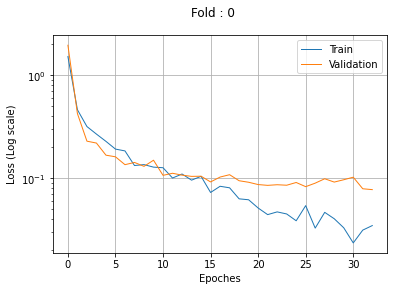

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(train_loss.keys()), list(train_loss.values()), linewidth=1, label="Train")
plt.plot(list(valid_loss.keys()), list(valid_loss.values()),  linewidth=1, label="Validation")
plt.suptitle('Fold : 0 ')
plt.xlabel('Epoches')
plt.ylabel('Loss (Log scale)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()